In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

#step 1: download everything
!pip install -q transformers
!pip install seqeval
!pip install -q datasets
!pip install -q evaluate


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 160, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 241, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 419, in run
    requirement_set = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 92, in resolve
    result = self._result = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 481, in resolve
    state = resolution.resolve(requi

In [ ]:
#step 1.1 import everything
import seqeval
import transformers
from transformers import AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification, TrainingArguments, Trainer, ElectraForTokenClassification
import torch
import json
import glob
import numpy as np
from datasets import load_dataset, Dataset
import evaluate

import os
os.chdir("/content/drive/My Drive/EMNLP/Final Project/ELECTRA")

In [ ]:
#step 1.2 is to upload the files
#I cloned the entire repo and manually uploaded to Colab
#then we open the files up
#I don't use the fce eng files, or the falko german files

In [ ]:
#step 1.3 use glob to gather all file names
#We are using the dev data as 
train_file_list = glob.glob("/content/*train.tsv")
test_file_list = glob.glob("/content/*dev.tsv")
print("TRAIN FILES:", train_file_list)
print("TEST FILES:", test_file_list)

TRAIN FILES: []
TEST FILES: []


In [ ]:
#These dictionaries show the correspondence between the numerical label and the real label
label2id = {"c": 1, "i": 0}
id2label = {1: "c", 0: "i"}

Transformer models make contextual embeddings based on sentence input. Because of this, we need to split the data into sentences, where each token in a sentence has a label attached. This is easy to do because the files we are working with have newlines in between sentences.

In [ ]:
def get_sentences(fin):
  """returns a list of sentences given a file"""

  sentences = []
  sentence = []
  with open(fin, "r") as inf:
    for line in inf:
      if line == "\n":
        #if we reach a newline, append the sentence to list and start over
        sentences.append(sentence)
        sentence = []
      else:
        #if we aren't at a newline, split into token and label and add to sent
        line = line.strip("\n")
        token, label = line.split("\t")
        token_label = (token, label)
        sentence.append(token_label)
        
  return sentences

For a multilingual experiment, we are going to combine all the languages together. I'm not actually using this function for this implementation (I just tested on Italian)

In [ ]:
def combine_all_sentences(train_list, test_list):
  """
  reads in all the files and combines them into giant lists of sents
  For monolingual setting we will need to do some extra work here to keep track of languages
  """
  train_sents = []
  for fin in train_list:
    # lang = fin.split("_")[0]
    sents = get_sentences(fin)
    train_sents += sents
  
  test_sents = []
  for fin in test_list:
    # lang = fin.split("_")[0]
    sents = get_sentences(fin)
    test_sents += sents

  return train_sents, test_sents

In [ ]:
def list_to_dataset(sent_list):
  """This function takes a list of lines with each token paired with its label in a tuple
  It returns a transformers dataset
  """
  data_dicts = []
  #we need an id value for a huggingface dataset
  id = 0
  for sent in sent_list:
    sent_dict = {}
    sent_dict['id'] = id
    id += 1

    tokens = [s[0] for s in sent]
    labels = [s[1] for s in sent]

    #convert "c" and "i" labels to numerical ones
    nums = [label2id[t] for t in labels]
    sent_dict["tokens"] = tokens
    sent_dict["labels"] = nums
    #append sentence dict to list
    data_dicts.append(sent_dict)

  #convert list of dictionaries into Dataset
  combined_dataset = Dataset.from_list(data_dicts)

  dataset = combined_dataset.train_test_split(test_size=0.2, shuffle=True, seed=34)

  dataset["dev"] = dataset["test"]

  del dataset["test"]

  return dataset

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
# def create_files_from_dataset(dev_set):
#   """
#   create ref and hyp files for eval script
#   this will write files to the colab directory, you can download them and then run eval.py
#   """
#   predictions = trainer.predict(dev_set)
#   true_predictions, true_labels = return_predictions(predictions)
#   with open("english_output_ref.tsv", "w") as ref_out:
#     with open("english_output_hyp.tsv", "w") as hyp_out:
#       for i in range(len(dev_set)):
#         tokens = dev_set[i]["tokens"]
#         labs = true_labels[i]
#         preds = true_predictions[i]
#         for j in range(len(tokens)):
#           tok = tokens[j]
#           p = preds[j]
#           l = labs[j]
#           ref_out.write(tok + "\t" + l + "\n")
#           hyp_out.write(tok + "\t" + p + "\n")
#         ref_out.write("\n")
#         hyp_out.write("\n")

#   return


In [ ]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [ ]:
def return_predictions(p):
    predictions, labels, metrics = p
    predictions = np.argmax(predictions, axis=2)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    return true_predictions, true_labels

Now that the functions are done, here is the actual experiment

In [ ]:
label_list = ["i","c"]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("dbmdz/electra-base-italian-xxl-cased-discriminator") # replace with different models

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [ ]:
seqeval = evaluate.load("seqeval")

In [ ]:
# replace with data
sents = get_sentences("/content/drive/My Drive/EMNLP/Final Project/italian/it_merlin_train.tsv")
dataset = list_to_dataset(sents)
tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/5115 [00:00<?, ? examples/s]

Map:   0%|          | 0/1279 [00:00<?, ? examples/s]

In [ ]:
# model = AutoModelForTokenClassification.from_pretrained(
#     "bert-base-multilingual-cased", num_labels=2, id2label=id2label, label2id=label2id
# )
model = ElectraForTokenClassification.from_pretrained("dbmdz/electra-base-italian-xxl-cased-discriminator", num_labels=2, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)

Some weights of the model checkpoint at dbmdz/electra-base-italian-xxl-cased-discriminator were not used when initializing ElectraForTokenClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForTokenClassification were not initialized from the model checkpoint at dbmdz/electra-base-italian-xxl-cased-discriminator and are newly initi

In [ ]:
training_args = TrainingArguments(
    output_dir="italian_electra_cased_discriminator",
    learning_rate=1e-6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    weight_decay=0.02,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["dev"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: ignored

In [ ]:
# predictions = trainer.predict(tokenized_dataset["dev"])

In [ ]:
# true_predictions, true_labels = return_predictions(predictions)


In [ ]:
# tokenized_dataset["dev"][0]

In [ ]:
# count = 0
# for i in true_predictions:
#   for x in i:
#     if x == "i":
#       count += 1

# true_count = 0
# for j in true_labels:
#   for y in j:
#     if y == "i":
#       true_count += 1

In [ ]:
def create_files_from_dataset(dev_set):
  """
  create ref and hyp files for eval script
  this will write files to the colab directory, you can download them and then run eval.py
  """
  predictions = trainer.predict(dev_set)
  true_predictions, true_labels = return_predictions(predictions)
  with open("italian_output_ref.tsv", "w") as ref_out:
    with open("italian_output_hyp.tsv", "w") as hyp_out:
      for i in range(len(dev_set)):
        tokens = dev_set[i]["tokens"]
        labs = true_labels[i]
        preds = true_predictions[i]
        for j in range(len(tokens)):
          tok = tokens[j]
          p = preds[j]
          l = labs[j]
          ref_out.write(tok + "\t" + l + "\n")
          hyp_out.write(tok + "\t" + p + "\n")
        ref_out.write("\n")
        hyp_out.write("\n")

  return


In [ ]:
create_files_from_dataset(tokenized_dataset["dev"])

So I just tested the results on italian so far, but the architecture would remain the same for the multilingual setting just with different models.

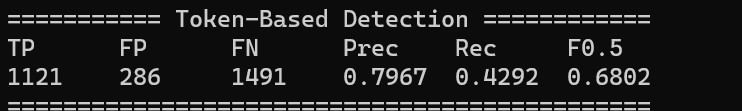